# Mirko Michele D'angelo - assignment no.1

# data preparation
First we load the dataset and process it.
Since NMHC(GT) has too many missing values it is not usable to make any valuable analysis so it is dropped, for the rest of the missing data we can do an imputation by averaging over the previous and successive observations for the same sensor if we have just one missing Value. For contiguous missing values we just go back on the same sensor, at the same hour, on the previous day and use that as our value.

In [1]:

!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo

# fetch dataset
air_quality = fetch_ucirepo(id=360)

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
# data cleaning
data=air_quality.data.features
# this column has way too many missing values so i drop it
data=data.drop(columns=["NMHC(GT)"])
data['DateTime']=pd.to_datetime(data['Date'])+pd.to_timedelta(data['Time'])
# remove single missing values and use the average between the previous and next assignment
for k in data.keys():
  missing=data[ data[k] == -200 ].index
  for idx in missing:
    prev=data.loc[idx+1,k]
    next=data.loc[idx-1,k]
    # skip if there are contiguous missing values
    if prev != -200 and next != -200:
      data.loc[idx,k]=(prev+next)/2

# replace contiguous missing values with same value from the same sensor from the day before
for k in data.keys():
  missing=data[ data[k] == -200 ].index
  for idx in missing:
    imputation=data[data['DateTime']==data.loc[idx,'DateTime']-pd.Timedelta(hours=24)]
    data.loc[idx,k]=imputation.iloc[0][k]
data['Date']=pd.to_datetime(data['Date'])


C:\Users\mirda\AppData\Local\Temp\ipykernel_18528\1476714503.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '993.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[idx,k]=(prev+next)/2
C:\Users\mirda\AppData\Local\Temp\ipykernel_18528\1476714503.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1114.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[idx,k]=(prev+next)/2
C:\Users\mirda\AppData\Local\Temp\ipykernel_18528\1476714503.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '51.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[idx,k]=(prev+next)/2
C:\Users\mirda\AppData\Local\Temp\ipykernel_18528\1476714503.py:

After loading and processing the data we can observe raw plots of the data:

<Axes: title={'center': 'T'}, xlabel='Date'>

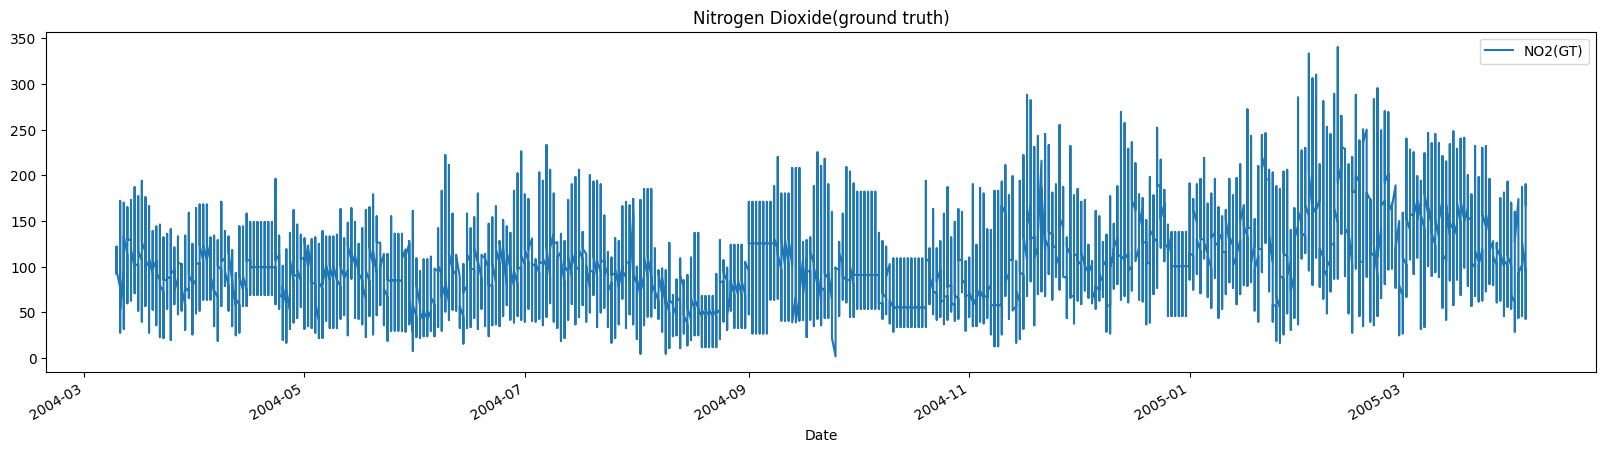

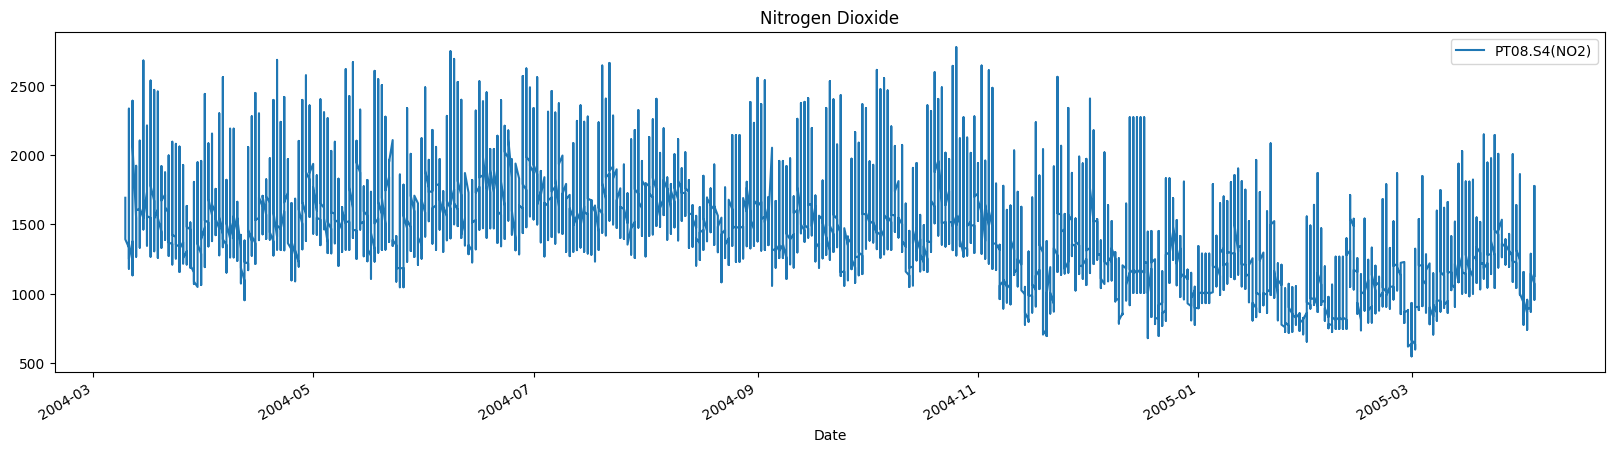

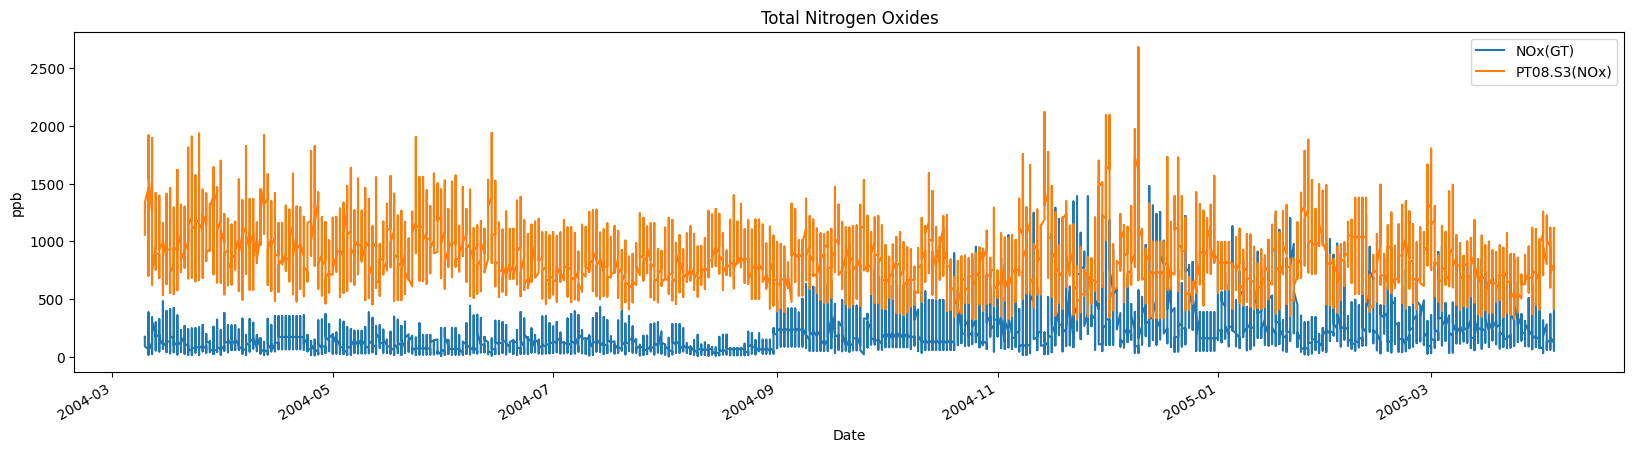

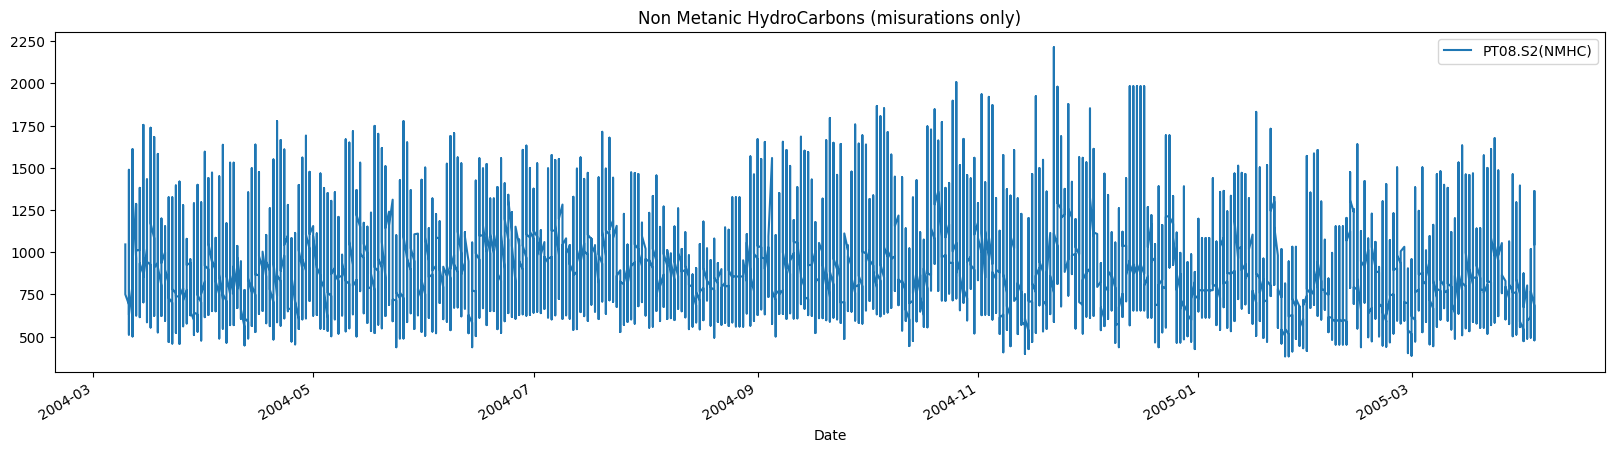

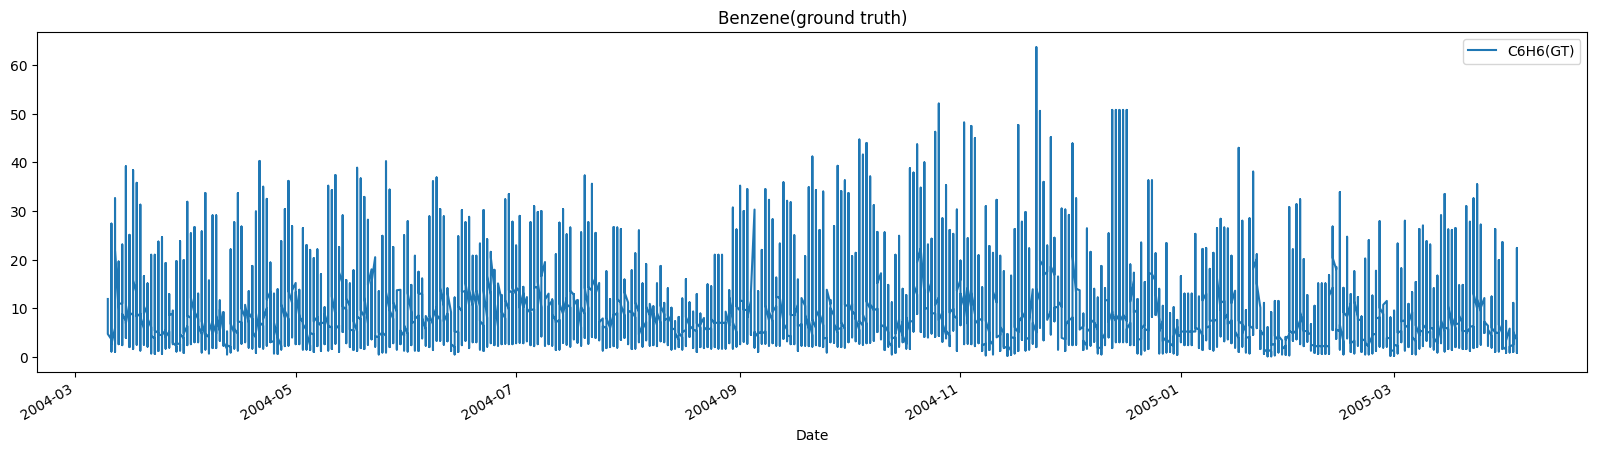

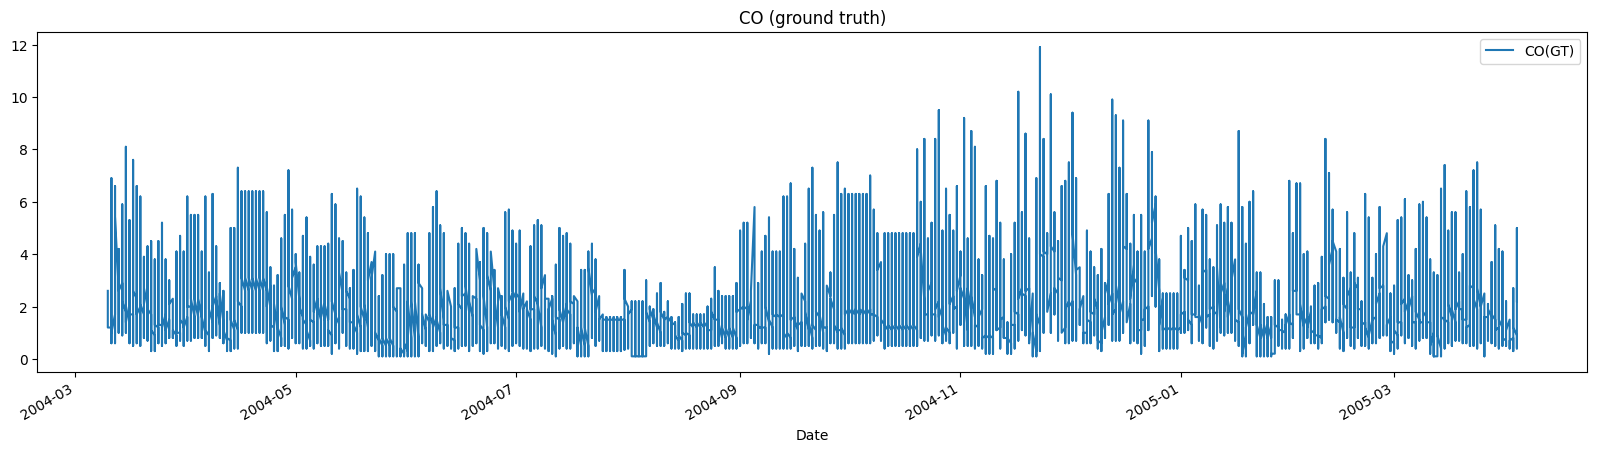

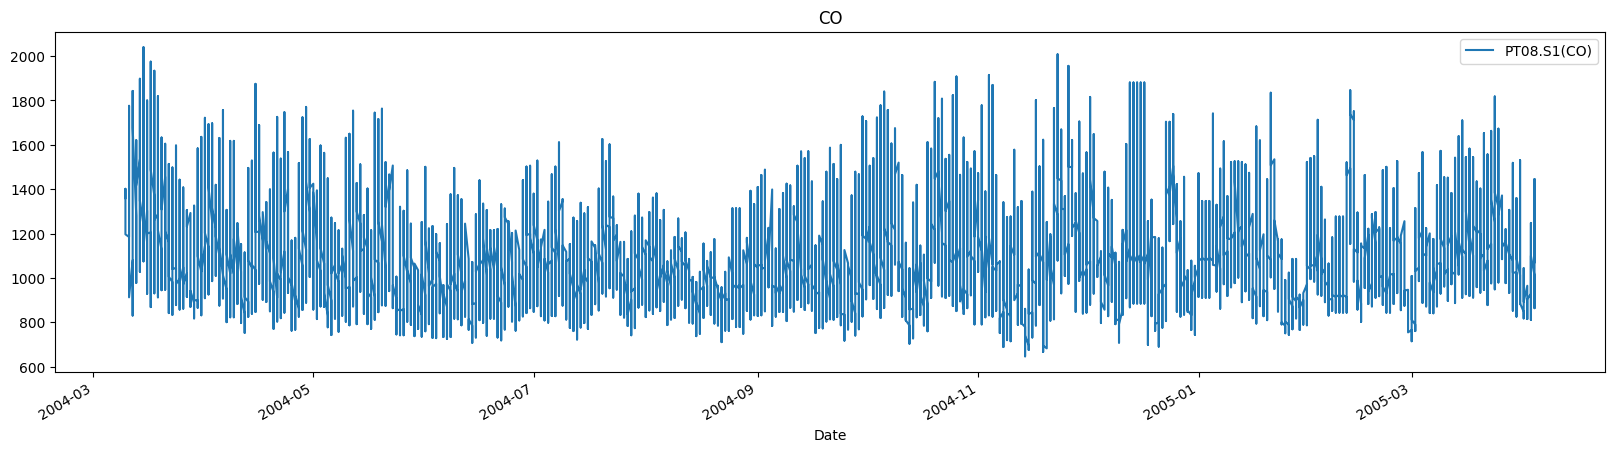

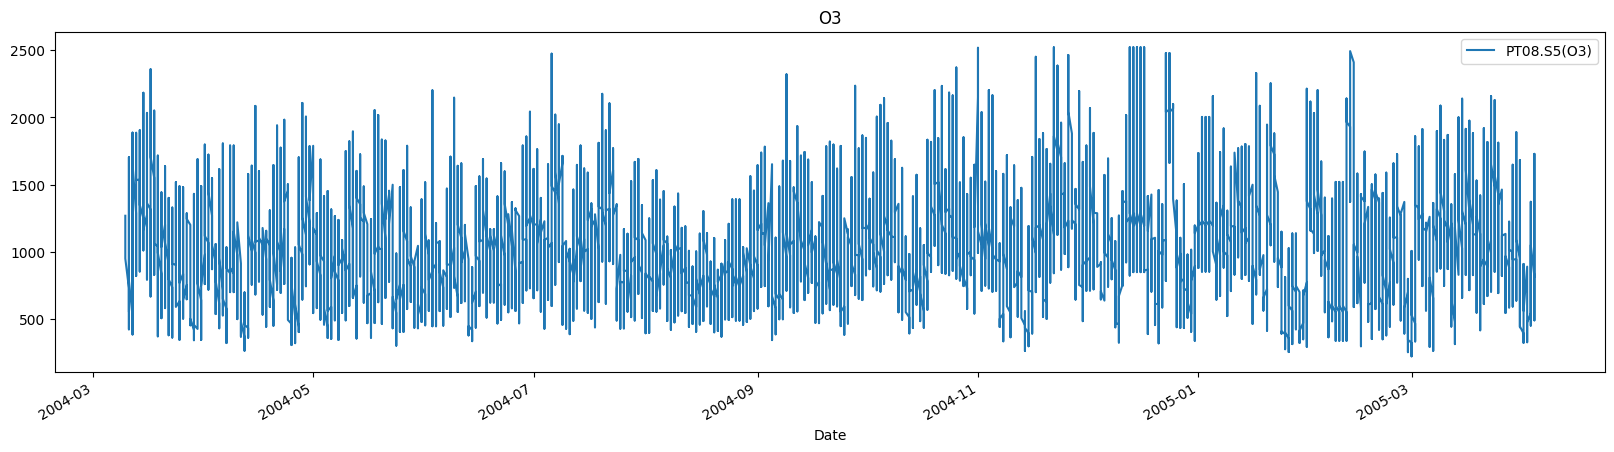

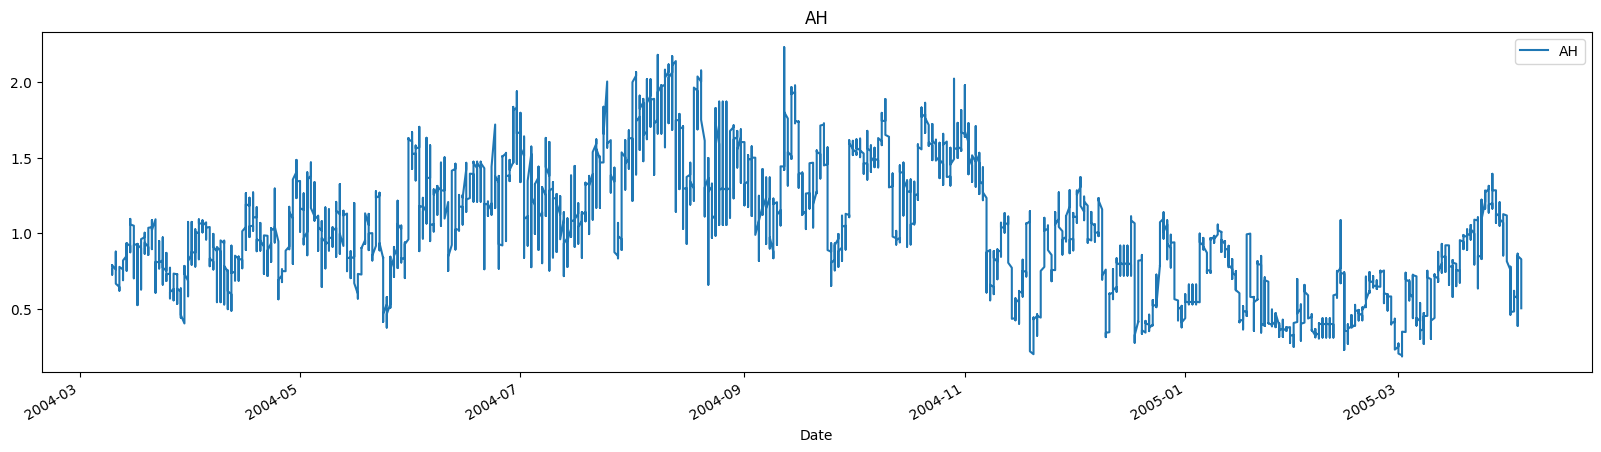

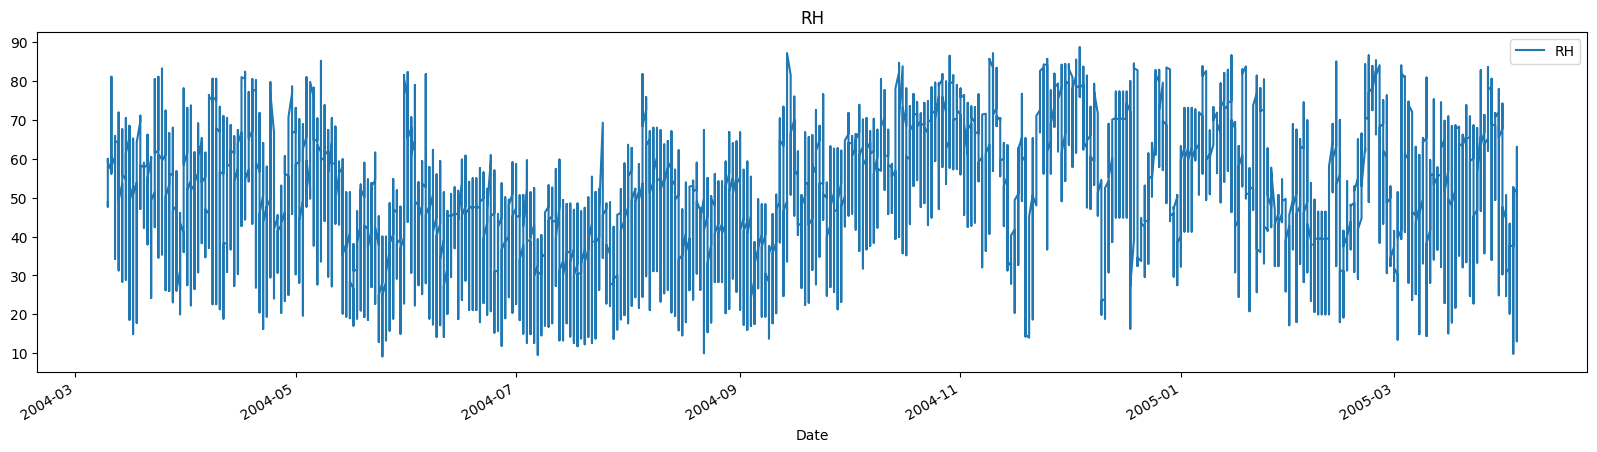

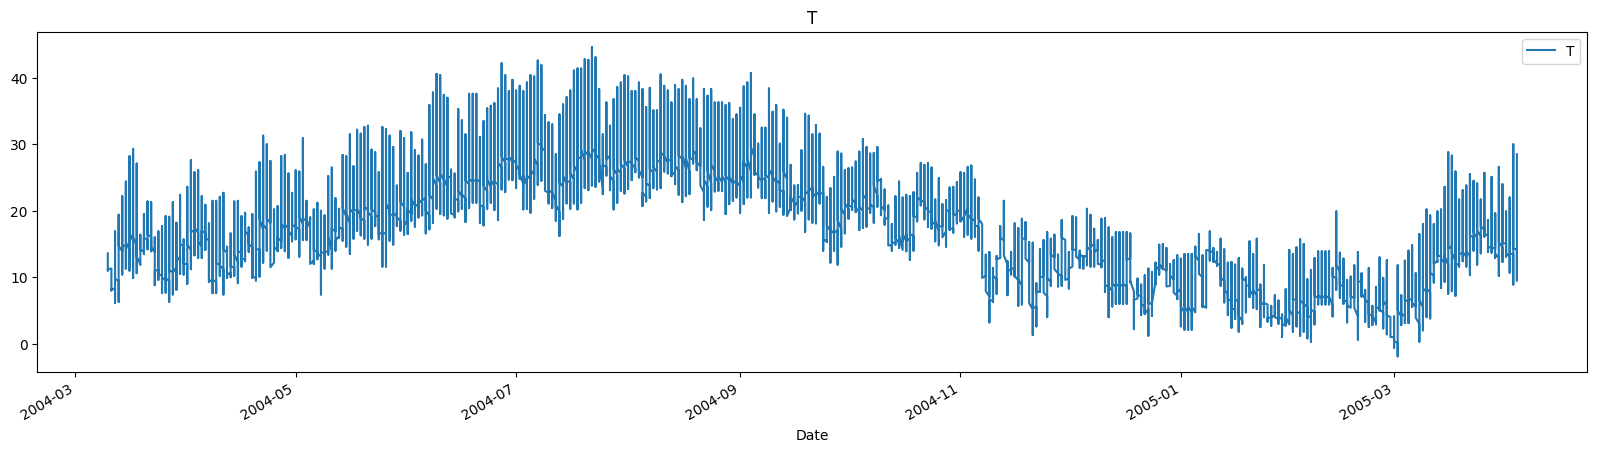

In [3]:
data[['Date','NO2(GT)']].plot(figsize=(20,5),x='Date',title='Nitrogen Dioxide(ground truth)')
data[['Date','PT08.S4(NO2)']].plot(figsize=(20,5),x='Date',title='Nitrogen Dioxide')
data[['Date','NOx(GT)','PT08.S3(NOx)']].plot(figsize=(20,5),x='Date',title='Total Nitrogen Oxides',ylabel='ppb')
data[['Date','PT08.S2(NMHC)']].plot(figsize=(20,5),x='Date',title='Non Metanic HydroCarbons (misurations only)')
data[['Date','C6H6(GT)']].plot(figsize=(20,5),x='Date',title='Benzene(ground truth)')
data[['Date','CO(GT)']].plot(figsize=(20,5),x='Date',title='CO (ground truth)')
data[['Date','PT08.S1(CO)']].plot(figsize=(20,5),x='Date',title='CO')
data[['Date','PT08.S5(O3)']].plot(figsize=(20,5),x='Date',title='O3')
data[['Date','AH']].plot(figsize=(20,5),x='Date',title='AH')
data[['Date','RH']].plot(figsize=(20,5),x='Date',title='RH')
data[['Date','T']].plot(figsize=(20,5),x='Date',title='T')

As we can see the data is in different scales even for sensors of the same polluting agent.
To avoid the issue of working with different scales we subtract the mean for each time series from itself.

In [4]:
df=data.drop(['Time','Date','DateTime'],axis=1)
normalized_df= (df-df.mean())

Now we can start with the analysis of the time series thorugh cross-correlation .

## cross correlation
To calculate the cross correlation we use two support function that implement the formula for the cross correlation and another one which calculates cross correlation with lags in the range $[-\tau,+\tau]$ for a given lag_range=$\tau$.

In [5]:
from math import floor
import matplotlib.pyplot as plt
#plots cross-correlation data
def display_corr(data,title=''):
  nlags= floor(len(data)/2)
  x_axis=range(-nlags,nlags)
  plt.figure(figsize=(20,5))
  plt.plot(x_axis,data)
  plt.ylim([-1,1])
  plt.xlim([-nlags,nlags])
  plt.grid()
  plt.xlabel('lag')
  plt.axhline(0,color='red')
  plt.title(title)
  plt.show()
#calculate cross correlation or normalized cross correlation depending on normalized flag
def cross_correlation(data,x1,x2,lag,normalized=False):
  res=sum(data[x2].mul(data[x1].shift(-lag,fill_value=0)))
  if normalized:
    res/=np.sqrt(sum(data[x1]**2)*sum(data[x2]**2))
  return res
# calculate the cross correlation in range of values of [-lag,+lag]
def ranged_crosscor(data,x1,x2,lag,normalized=False):
  return [cross_correlation(data,x1,x2,l,normalized) for l in range(-lag,lag)]

lag_range=9357

To analyze better the correlation between all sensors we can confront them one by one: for each pair we calculate normalized cross-correlation and we save the highest and lowest cross-correlation values along with their corresponding lag. 

The code below does the computation described above and returns the results of the correlations in a table format where each column has the following meaning:
- 'sensors1': one of the sensors being correlated.
- 'sensors2': the sensor being correlated.
- 'max_value': the highest correlation obtained.
- 'max_lag': the lag correseponding to the highest normalized cross-correlation.
- 'min_value': the lowest correlation obtained.
- 'min_lag': the lag correseponding to the lowest normalized cross-correlation.

Note: Even if time series have their mean subtracted they might have different magnitudes and cross correlation will different magnitudes aswell so in order to confront them correctly we use the normalized cross correlation.

### sensors correlation


In [6]:
import itertools as it
def correlate_sets(data,x1,x2,lag_range):
  already_seen=set()
  sensors_df=pd.DataFrame(columns=['sensor1','sensor2','max_lag','max_value','min_lag','min_value'])
  for r,(x1,x2) in enumerate(it.product(x1,x2)):
    # avoid repeating cross correlations between two sensors and avoid correlation of a sensor with itself
    if x1!=x2 and ((x2,x1) not in already_seen):
      already_seen.add((x1,x2))
      res=ranged_crosscor(normalized_df,x1,x2,lag_range,normalized=True)
      maxv=np.max(res)
      minv=np.min(res)
      sensors_df.loc[r]= {
                        'sensor1':x1,
                        'sensor2':x2,
                        'max_lag':np.argmax(res)-lag_range,
                        'max_value:':maxv,
                        'min_lag':np.argmin(res)-lag_range,
                        'min_value:':minv
                      }
      print({
                        'sensors':x1+'-'+x2,
                        'max_lag':np.argmax(res)-lag_range,
                        'max_value:':maxv,
                        'min_lag':np.argmin(res)-lag_range,
                        'min_value:':minv
                      })
      sensors_df.loc[r,'max_value']=maxv
      sensors_df.loc[r,'min_value']=minv
  return sensors_df

Now we can calculate all the cross correlations between sensors.

The values obtained can be useful to find information about the data.

In [7]:
sensors=['PT08.S1(CO)','PT08.S2(NMHC)','PT08.S3(NOx)','PT08.S4(NO2)','PT08.S5(O3)','RH','AH','T','C6H6(GT)' ,'NO2(GT)','CO(GT)' ,'NOx(GT)']
sensors_correlation=correlate_sets(normalized_df,sensors,sensors,lag_range)

{'sensors': 'PT08.S1(CO)-PT08.S2(NMHC)', 'max_lag': 0, 'max_value:': 0.8947414989584407, 'min_lag': 1073, 'min_value:': -0.17981193151467562}
{'sensors': 'PT08.S1(CO)-PT08.S3(NOx)', 'max_lag': 375, 'max_value:': 0.18801069879631072, 'min_lag': 0, 'min_value:': -0.774042060333349}
{'sensors': 'PT08.S1(CO)-PT08.S4(NO2)', 'max_lag': 0, 'max_value:': 0.67804941463002, 'min_lag': 402, 'min_value:': -0.1840876552085203}
{'sensors': 'PT08.S1(CO)-PT08.S5(O3)', 'max_lag': 0, 'max_value:': 0.9002246816213278, 'min_lag': 1073, 'min_value:': -0.16946111799014874}
{'sensors': 'PT08.S1(CO)-RH', 'max_lag': -12, 'max_value:': 0.4650167195922522, 'min_lag': -2618, 'min_value:': -0.2705520841733941}
{'sensors': 'PT08.S1(CO)-AH', 'max_lag': -4092, 'max_value:': 0.16982668793527886, 'min_lag': -1293, 'min_value:': -0.19400838263787826}
{'sensors': 'PT08.S1(CO)-T', 'max_lag': -3915, 'max_value:': 0.20976994728676668, 'min_lag': -444, 'min_value:': -0.3003661596808801}
{'sensors': 'PT08.S1(CO)-C6H6(GT)', 'm

# Results
This section reports the results of the analysis done with the cross correlation.
## polluting agents sensors
The tables below report the correlations values between sensors of polluting agents, by looking at the max_value column we can see that almost all the sensors have a really high correlation whether they are of the reference analyzers or the sensors on the street. The PT08.S3(NOx) sensor is the only one that exhibits a different behavior by having an anti-correlation almost with all the other sensors.

In [8]:
#confronting polluting agent sensors
sensors1=['PT08.S1(CO)','PT08.S2(NMHC)','PT08.S4(NO2)','PT08.S5(O3)','C6H6(GT)' ,'NO2(GT)','CO(GT)','NOx(GT)']
sensors_correlation[sensors_correlation['sensor1'].isin(sensors1) & sensors_correlation['sensor2'].isin(sensors1) ].sort_values('max_value',ascending=False)

,sensor1,sensor2,max_lag,max_value,min_lag,min_value
20,PT08.S2(NMHC),C6H6(GT),0,0.981649,-1071,-0.178023
4,PT08.S1(CO),PT08.S5(O3),0,0.900225,1073,-0.169461
1,PT08.S1(CO),PT08.S2(NMHC),0,0.894741,1073,-0.179812
8,PT08.S1(CO),C6H6(GT),0,0.885417,-1048,-0.172925
16,PT08.S2(NMHC),PT08.S5(O3),0,0.879602,1049,-0.219650
56,PT08.S5(O3),C6H6(GT),0,0.865284,-1049,-0.206593
106,C6H6(GT),CO(GT),0,0.855460,-401,-0.165812
22,PT08.S2(NMHC),CO(GT),0,0.845196,-399,-0.204373
10,PT08.S1(CO),CO(GT),0,0.830702,-2608,-0.193364
58,PT08.S5(O3),CO(GT),0,0.795828,3103,-0.159399


Here most of the sensors have a max_value above 0.6 and up to 0.98, a min_value that is close 0, also the lag of the max_values is 0.

In [9]:
#confronting PT08.S3(NOx) with all the other sensors
sensors1=['PT08.S3(NOx)']
sensors_correlation[sensors_correlation['sensor1'].isin(sensors1) | sensors_correlation['sensor2'].isin(sensors1) ].sort_values('min_value')

,sensor1,sensor2,max_lag,max_value,min_lag,min_value
14,PT08.S2(NMHC),PT08.S3(NOx),1047,0.210597,0,-0.797559
28,PT08.S3(NOx),PT08.S5(O3),1050,0.165611,0,-0.796264
2,PT08.S1(CO),PT08.S3(NOx),375,0.188011,0,-0.774042
32,PT08.S3(NOx),C6H6(GT),-375,0.207525,0,-0.735815
34,PT08.S3(NOx),CO(GT),-351,0.239962,0,-0.660483
35,PT08.S3(NOx),NOx(GT),-4638,0.179561,0,-0.638384
33,PT08.S3(NOx),NO2(GT),1642,0.159371,0,-0.625697
27,PT08.S3(NOx),PT08.S4(NO2),-376,0.243347,0,-0.535136
29,PT08.S3(NOx),RH,1270,0.199397,-11,-0.386470
30,PT08.S3(NOx),AH,-3117,0.263460,-11,-0.233132


In this table we can see that the situation is quite the opposite, all the pollution sensors have an anti-correlation with PT08.S3(NOx) that goes below -0.5 and the corresponding min_lag of 0.

The high correlations might be explained by the fact that the polluting agents come from the same sources, for example the exhaust gas of vehicles, so they will have similar behavior and will vary their concetration together. The only exception is PT08.S3(NOx) sensor that has a strange anticorrelation.

Below we report two graphs, one for two highly correlated sensors and another to show the anti-correlation of PT08.S3(NOx) with the other sensors, all the other sensor with high correlation or anti correlation have more or less the same shape.

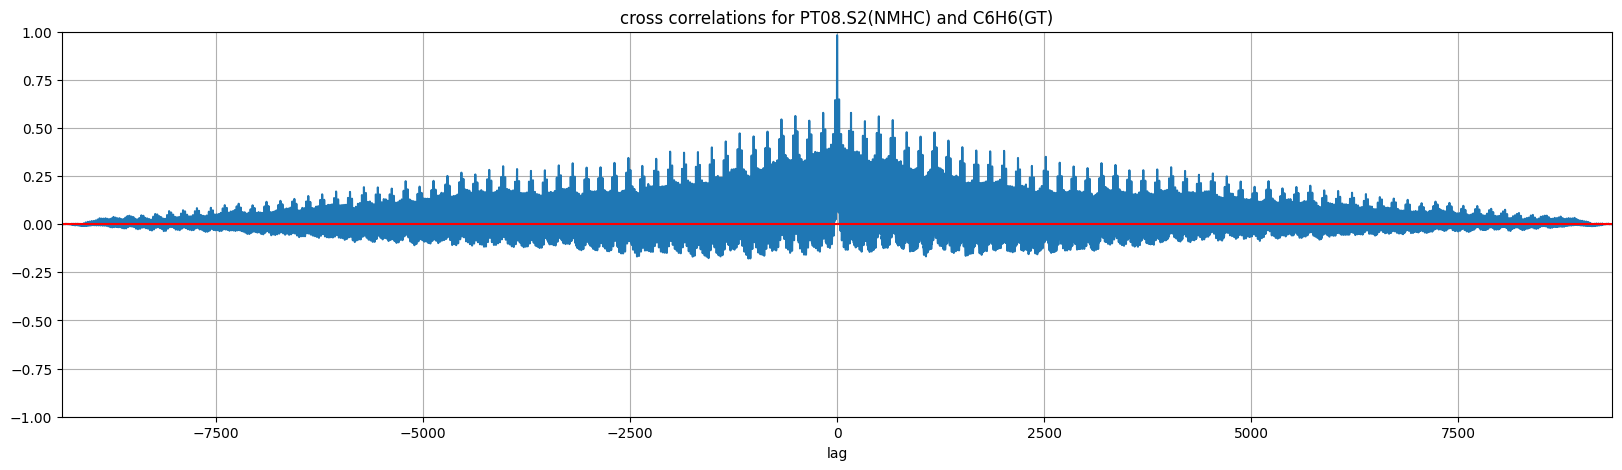

In [10]:
display_corr(ranged_crosscor(normalized_df,'PT08.S2(NMHC)','C6H6(GT)',lag=lag_range,normalized=True),'cross correlations for PT08.S2(NMHC) and C6H6(GT)')

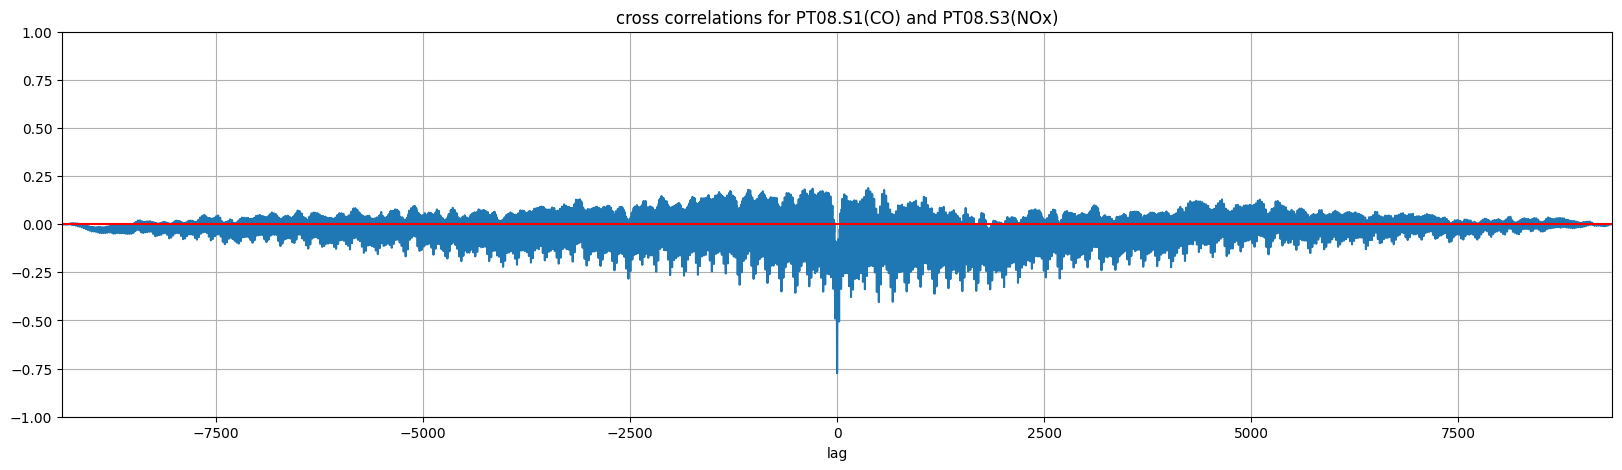

In [11]:
display_corr(ranged_crosscor(normalized_df,'PT08.S1(CO)','PT08.S3(NOx)',lag=lag_range,normalized=True),'cross correlations for PT08.S1(CO) and PT08.S3(NOx)')

In both the graphs we can notice a really high variations of the cross-correlation value, meaning that the time series have high variations of their values over time. They also show a really high/low peak for lag 0 meaning that that all the sensors have a strong relationship between each other without any time delay.

Below we can see that every 24 hour we have a trend where the correlation goes up meaning that the the concetration of the polluting agents has a cyclic behavior, this caused by the fact that all the sensor are placed in a city where vehicles are more active during the day, usually between working hours, and way less during the night causing a repeating pattern in the data.

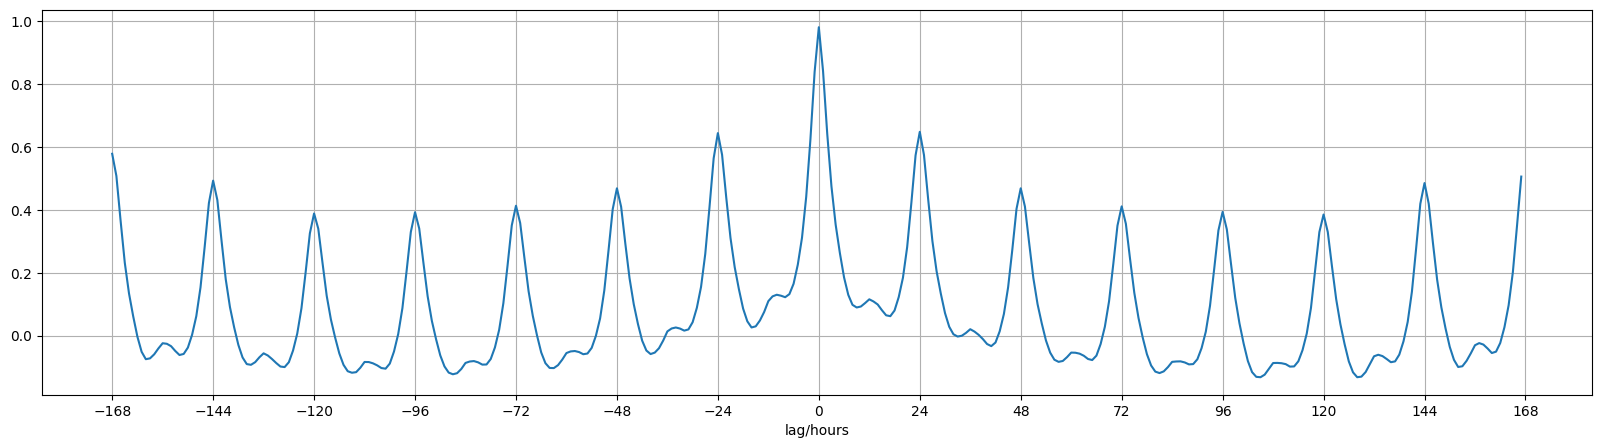

In [12]:
plt.figure(figsize=(20,5))
plt.plot(range(-24*7,24*7),ranged_crosscor(normalized_df,'PT08.S2(NMHC)','C6H6(GT)',lag=24*7,normalized=True))
plt.xticks(range(-24*7,24*8,24))
plt.grid()
plt.xlabel('lag/hours')
plt.show()

## ground truths comparison with sensors

From the graphs below we can see that the ground truths and their respective sensor don't always have the same behavior. For the CO we have a high correlation but for NO2 we have a weak correlation and for NOx, as already shown, an anticorrelation. The strange difference in behavior might be explained by the fact that PT08 sensors have are more sensitive or les precise w.r.t. their reference analyzer or the reference analyzer is not at the road level but in the same area and so it is less influenced by the exhaust gasses.

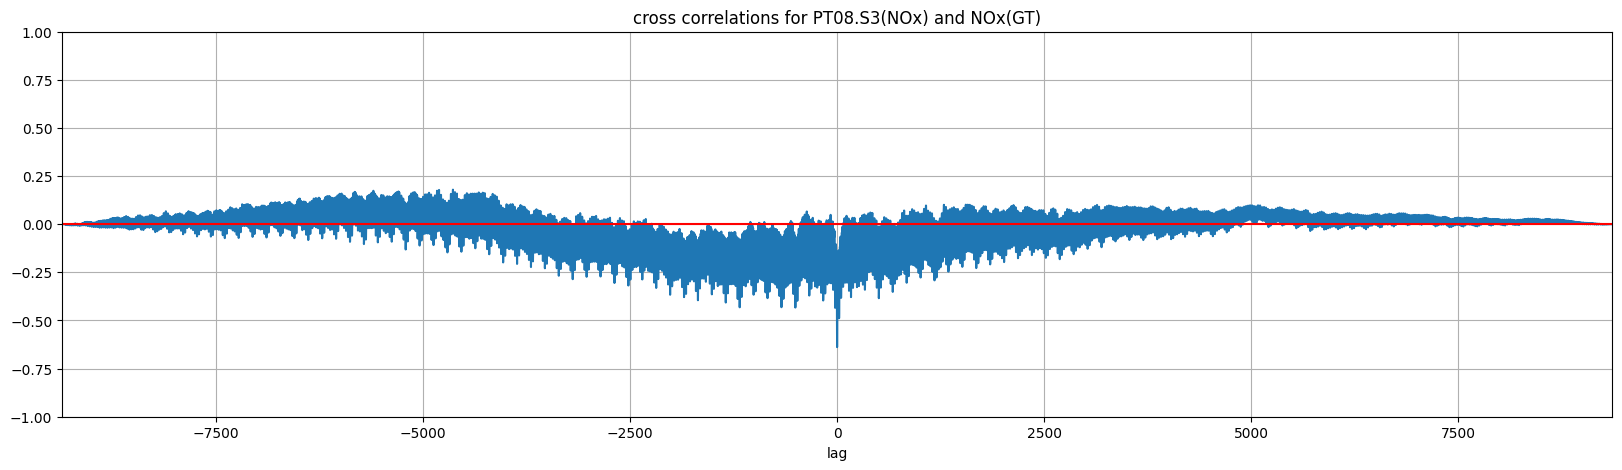

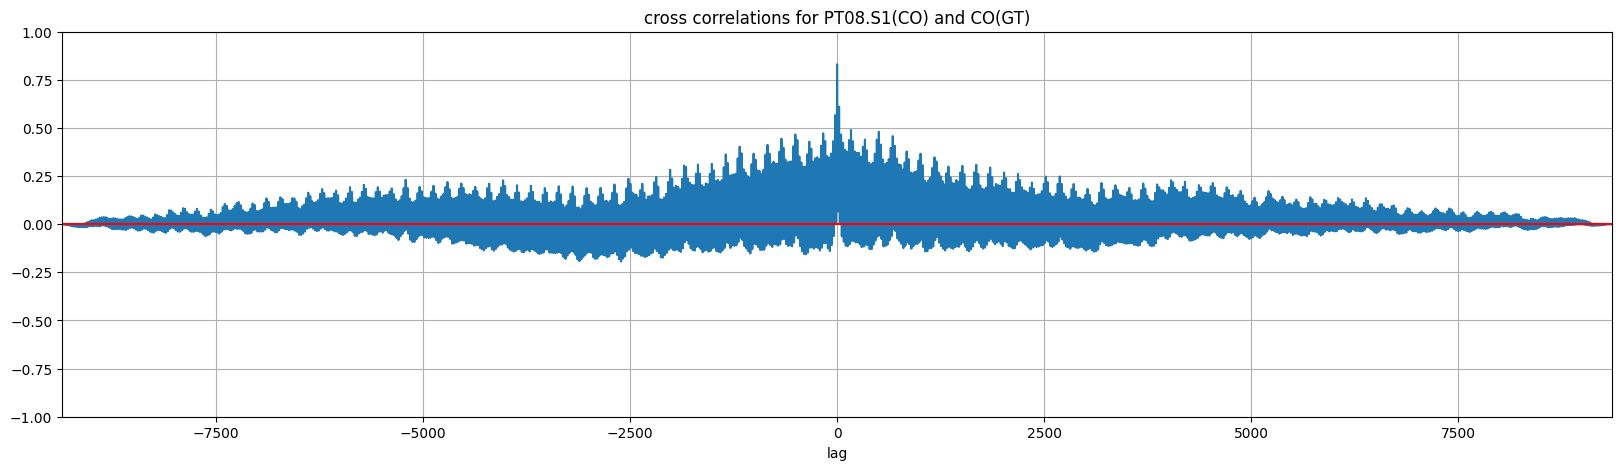

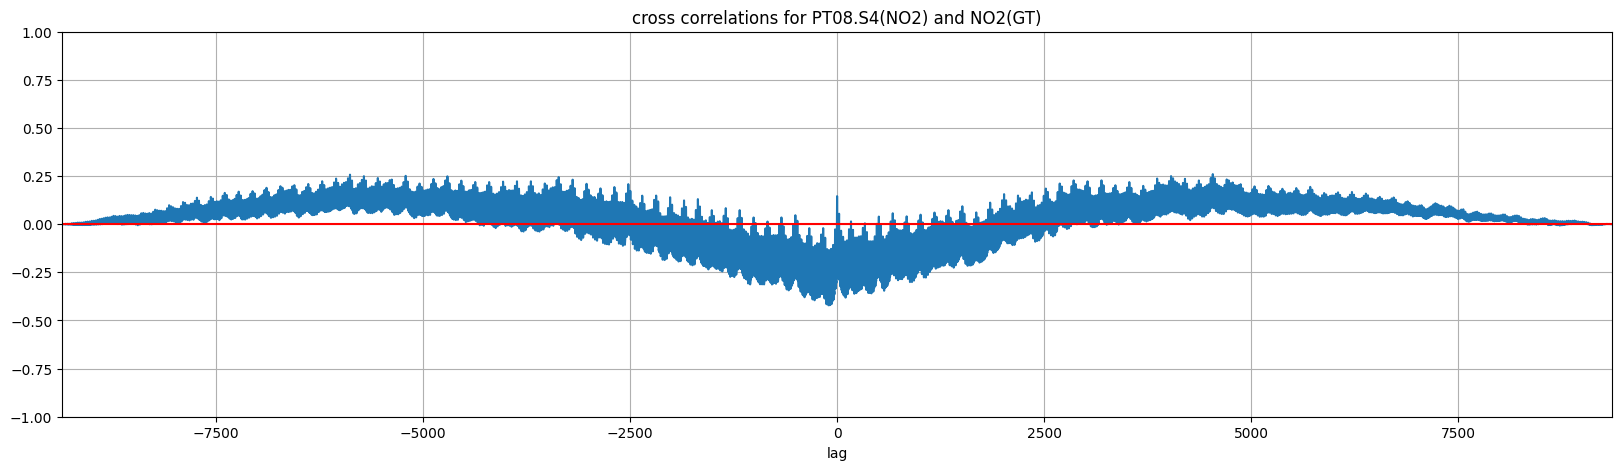

In [13]:
display_corr(ranged_crosscor(normalized_df,'PT08.S3(NOx)','NOx(GT)',lag=lag_range,normalized=True),'cross correlations for PT08.S3(NOx) and NOx(GT)')
display_corr(ranged_crosscor(normalized_df,'PT08.S1(CO)','CO(GT)',lag=lag_range,normalized=True),'cross correlations for PT08.S1(CO) and CO(GT)')
display_corr(ranged_crosscor(normalized_df,'PT08.S4(NO2)','NO2(GT)',lag=lag_range,normalized=True),'cross correlations for PT08.S4(NO2) and NO2(GT)')

## temperature correlations
The temperature sensors doesn't show any strong correlation with all the other sensors except for a high correlation with AH and an anticorrelation with RH.

This actually makes sense since warm air can has more water vapor than cold air, hence it has a higher absolute humidity and when one goes up or down so does the other. For relative humidity instead we can justify the anticorrelation with the temperature with the fact that the are inversely proportinal by definition of the relative humidity.

In [14]:
sensors1=['T']
sensors_correlation[sensors_correlation['sensor1'].isin(sensors1) | sensors_correlation['sensor2'].isin(sensors1) ].sort_values('max_value',ascending=False)

,sensor1,sensor2,max_lag,max_value,min_lag,min_value
79,AH,T,10,0.719886,-3240,-0.389534
43,PT08.S4(NO2),T,-3,0.599752,4284,-0.416248
95,T,NOx(GT),-3503,0.383110,996,-0.522547
67,RH,T,3012,0.353848,0,-0.574096
31,PT08.S3(NOx),T,-2340,0.349256,1822,-0.184083
93,T,NO2(GT),-4440,0.348094,-61,-0.544681
94,T,CO(GT),-2497,0.260549,443,-0.339473
19,PT08.S2(NMHC),T,1822,0.260533,4645,-0.242230
92,T,C6H6(GT),-1822,0.246094,1788,-0.241374
55,PT08.S5(O3),T,2494,0.221641,-1308,-0.291467


This table shows that aside from AH and RH all the other sensors do not show any strong correlation or anti-correlation with the temperature with both max_value and min_value being near 0 for almost all pollution sensors, moreover their max_lag and min_lag values are really different and don't show any kind alignment.

Below we have a graph of the cross-correlation across different lag values has been reported, here the cross-correlation values don't vary a lot over time and might be because temperature and humidity don't vary as fast as the polluting agents do so this explain the sinusodial shape of the graph and the fact that the cross-correlation values have low variance.


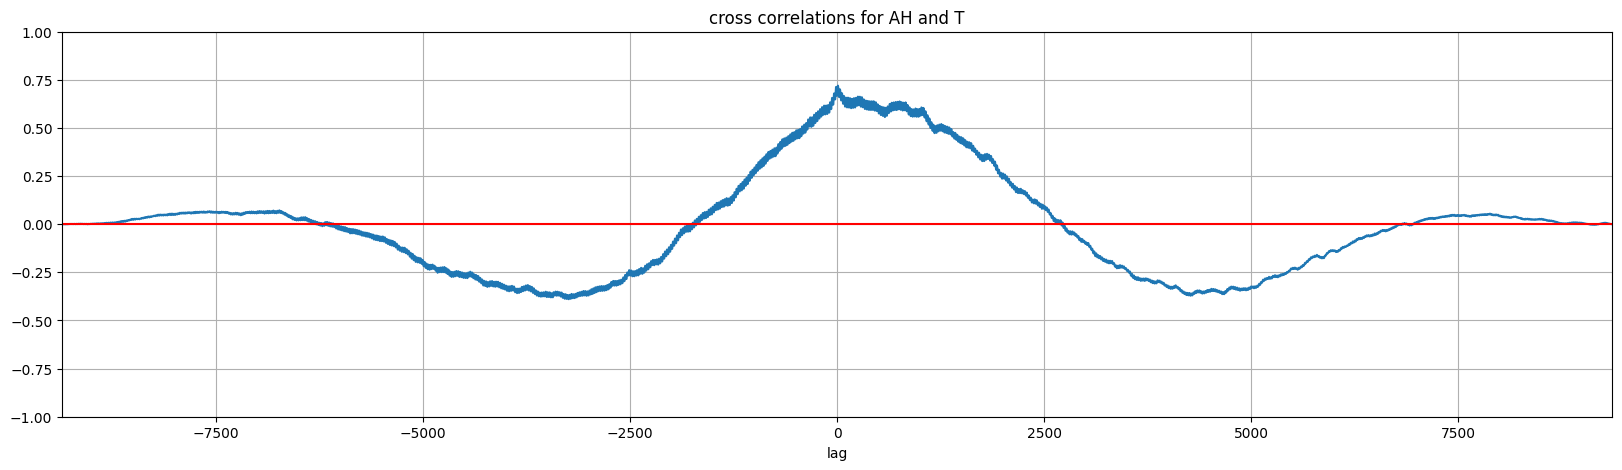

In [15]:
display_corr(ranged_crosscor(normalized_df,'AH','T',lag=lag_range,normalized=True),'cross correlations for AH and T')

From the table below we can see that the sensors for absolute humidity and relative humidity we don't have any particularly strong correlation with other polluting sensors so we can deduct that it doesn't really have a relationship with the polluting agents.

In [16]:
sensors1=['AH','RH']
sensors_correlation[sensors_correlation['sensor1'].isin(sensors1) | sensors_correlation['sensor2'].isin(sensors1) ].sort_values('max_value',ascending=False)

,sensor1,sensor2,max_lag,max_value,min_lag,min_value
79,AH,T,10,0.719886,-3240,-0.389534
42,PT08.S4(NO2),AH,-1,0.636978,3578,-0.321720
71,RH,NOx(GT),12,0.474916,-3815,-0.292923
5,PT08.S1(CO),RH,-12,0.465017,-2618,-0.270552
70,RH,CO(GT),11,0.446046,-3096,-0.250414
69,RH,NO2(GT),-1141,0.422637,-4440,-0.290654
17,PT08.S2(NMHC),RH,-12,0.385535,2327,-0.296692
68,RH,C6H6(GT),12,0.368856,-2326,-0.276278
53,PT08.S5(O3),RH,-11,0.362809,2926,-0.208815
67,RH,T,3012,0.353848,0,-0.574096


Here we see that we follow the same trend of the temperature, almost all of the values of min_value and max_value for the pollution sensors are within a range of \[-0.5,+0.5\] aside for exception, for min_lag and max_lag we don't have, again, a clear trend. 

# considerations
Cross-correlations is a good method to find correlations between time series in the time domain but only finds linear correlations between data, assumes the time series to be stationary to work and is also very sensitive to noise when it is too much, also time series are not very good to find 

For this assignment the cross-correlation has been useful to find relationship between the different sensors but the limited interpretability of the cross-correlation doesn't help undestanding possibile causes for behavior of the different signals, but it is a good starting point to further analyze the data with a method that is cheap to compute and easy to interpret.